[<img src="https://user-images.githubusercontent.com/79705081/109483674-d3eea600-7a7f-11eb-9a25-58c50da4cde9.png">](http://edenlibrary.ai/)

# Weeds Identification-Transfer Learning-2

### Instructions
1. Clone the repository.
2. Download the necessary datasets from Eden Repository:
   1. Cotton-10/JUN/2019-v1
   2. Velvet leaf-22/MAY/2019-v1
3. Unzip dataset files and remove the zip files.
4. Create a folder called 'eden_data'.
5. Move the unzipped datasets into this folder.
6. The resulting directory structure should be:
    * eden_library_notebooks/images_classification/
       * weeds_identification-transfer_learning-2.ipynb
       * eden_data/
           * Cotton-Gossypium Herbaceum-100619-Healthy-zz
           * Velvet leaf-Abutilon Theophrasti-220519-Weed-zz
7. Install notebook dependencies by running:
    <pre><code>conda env create -f eden_transfer_learning.yml</code></pre>
8. Open the notebook: jupyter notebook
9. Run the code

## Background

In this notebook, we are gonna cover a technique called **Transfer Learning**, which generally refers to a process where a machine learning model is trained on one problem, and afterwards, it is reused in some way on a second (probably) related problem (Bengio, 2012). Specifically, in **deep learning**, this technique is used by training only part of the layers of the network, which was previously trained. Its promise is that the training will be more efficient and in the best of the cases the performance will be better in comparison to a model trained from scratch.

In **agriculture**, since **weeds** compete with crops in the domain of space, light and nutrients, they are an important problem that can lead to a poorer harvest by farmers. To avoid this, weeds should be removed at every step of the growth, but especially at the initial stages. For that reason, identifying weeds accurately by deep learning has arisen as an important objective. Related to this, we can find the disease detection problem, where transfer learning has also been used. Among the most relevant recent works, we can find:

**Wang et al., (2017)** used transfer learning in order to obtain the best neural-based method for disease detection in plants. They extended the apple black rot images in the PlantVillage dataset, which were further annotated by botanists with four severity stages as ground truth. Then, they evaluated the performances of shallow networks trained from scratch and deep models fine-tuned by transfer learning. Their best model was the **VGG16** architecture trained with transfer learning, which yielded an overall accuracy of 90.4% on the hold-out test set. In **Mehdipour-Ghazi et al., (2017)**, the authors used the plant datasets of LifeCLEF 2015. Three popular deep learning architectures were evaluated: **GoogLeNet, AlexNet, and VGGNet**.  Their best combined system (a combination of GoogleNet and VGGNet) achieved an overall accuracy of 80% on the validation set and an overall inverse rank score of 0.752 on the official test set. In **Suh et al., (2018)**, the authors compared different transfer learning approaches in order to find a suitable approach for weed detection (volunteer potato). Their highest classification accuracy for **AlexNet** was 98.0%. Comparing different networks, their highest classification accuracy  was 98.7%, which was obtained with **VGG-19**. Additionally, all scenarios and pre-trained networks were feasible for real-time applications (classification time < 0.1 s). Another relevant study has been performed by **Kounalakis et al., (2019)** where they evaluated transfer learning by a combination of CNN-based feature extraction and linear classifiers to recognize rumex under real-world conditions. Their best system (**Inception_v1**+L2regLogReg) achieved an accuracy of 96.13 with a false positive rate of 3.62. In **Too et al., (2019)**, the authors used transfer learning achieving a performance of 99.75% with the **DenseNet** architecture. Finally, in **Espejo-Garcia et al., (2020)**, authors used transfer learning using agricultural datasets for pre-training neural networks, and afterwards, they fine-tuned the networks for classifying 4 species extracted from the **Eden Platform**. Their maximum performance was 99.54% by using the **Xception** architecture.

**UPDATES**

*  ***06/04/2021*** Added learning Curves plots.
*  ***06/04/2021*** Improved accuracy by **11%** with different dropout  and learning rate.


#### Library Imports

In [2]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import cv2
import os
from tqdm import tqdm
from glob import glob
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
import tensorflow as tf

from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Model

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications.inception_v3 import preprocess_input

from sklearn.metrics import f1_score
import tensorflow.keras.backend as K

import random
import matplotlib.pyplot as plt

#### Auxiliar Functions

In [4]:
def denormalise(values):
    # Some functions need 1-d arrays
    # This function transform n-dimensional y to 1-d y
    y_den = []
    for dist in values:
        y_den.append(np.argmax(dist))
    
    return y_den

In [5]:
#Function for plotting images.
def plot_sample(X):
   # Plotting 6 sample images
    nb_rows = 3
    nb_cols = 3
    fig, axs = plt.subplots(nb_rows, nb_cols, figsize=(6, 6))

    for i in range(0, nb_rows):
        for j in range(0, nb_cols):
            axs[i, j].xaxis.set_ticklabels([])
            axs[i, j].yaxis.set_ticklabels([])
            axs[i, j].imshow(X[random.randint(0, X.shape[0]-1)])

In [6]:
def read_data(path, im_size=(128,128)):
    
    X = []
    y = []
    #extracting the label name from data files.
    tag2idx = {tag:i for i, tag in enumerate(os.listdir(path))}
    
    for im_file in tqdm(glob(path + "*/*")):
        try:
            label = im_file.split("/")[1]
            im = cv2.imread(im_file)
            im = cv2.resize(im, im_size)
            im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
            X.append(im)
            y.append(tag2idx[label])  #appending the label names to y 
        except Exception as e:
            # In case annotations or metadata are found
            print("Not a picture")
    
    X = np.array(X)
    y = np.eye(len(np.unique(y)))[y].astype(np.uint8)
    
    return X, y

In [7]:
def get_callbacks(weights_file, patience, lr_factor):
    return [
        #Only save the weights that correspond to the maximum validation accuracy    
        ModelCheckpoint(filepath= weights_file,
                        monitor="val_accuracy",
                        mode="max",
                        save_best_only=True, 
                        save_weights_only=True),
        #If val_loss doesn't improve for a number of epochs set with 'patience' var 
        #training will stop to avoid overfitting.      
        EarlyStopping(monitor="val_loss",
                      mode="min",
                      patience = patience,
                      verbose=1),
        #Learning rate is reduced by 'lr_factor' if val_loss stagnates
        #for a number of epochs set with 'patience' var.      
        ReduceLROnPlateau(monitor="val_loss", mode="min",
                          factor=lr_factor, min_lr=1e-6, patience=patience//2, verbose=1)]

In [8]:
#Plot learning curves for both validation accuracy & loss,
#training accuracy & loss
def plot_training_curves(history):
        #Defining the metrics we will plot.
        train_acc=history.history['accuracy']
        val_acc=history.history['val_accuracy']
        train_loss = history.history['loss']
        val_loss = history.history['val_loss']
        
        #Range for the X axis.
        epochs = range(len(train_loss))
        
        #Plotting Loss figures.
        fig = plt.figure(figsize=(10,6)) #figure size h,w in inches 
        plt.rcParams.update({'font.size': 22}) #configuring font size.
        plt.plot(epochs,train_loss,c="red",label="Training Loss") #plotting
        plt.plot(epochs,val_loss,c="blue",label="Validation Loss")
        plt.xlabel("Epochs") #title for x axis
        plt.ylabel("Loss")   #title for y axis
        plt.legend()

        #Plotting Accuracy figures. 
        fig = plt.figure(figsize=(10,6)) #figure size h,w in inches
        plt.plot(epochs,train_acc,c="red",label="Training Acc") #plotting
        plt.plot(epochs,val_acc,c="blue",label="Validation Acc")
        plt.xlabel("Epochs")   #title for x axis
        plt.ylabel("Accuracy") #title for y axis
        plt.legend()

#### Experimental Constants

In [9]:
INPUT_SHAPE = (128, 128, 3)
IM_SIZE = (128, 128)
EPOCHS = 50
BATCH_SIZE = 8
TEST_SPLIT = 0.15
VAL_SPLIT = 0.15
RANDOM_STATE = 2020
WEIGHTS_FILE = "weights.h5"#File that stores updated weights
IM_PATH = 'eden_data/' # Path to the Eden data

#### Reading and showing pictures

In [10]:
X, y = read_data(IM_PATH, IM_SIZE)

100%|██████████| 176/176 [00:41<00:00,  4.22it/s]


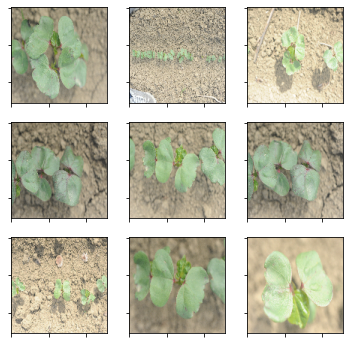

In [11]:
# Class 0
plot_sample(X[:50])

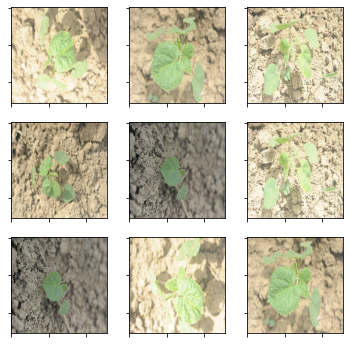

In [12]:
# Class 1
plot_sample(X[-50:])

#### Architecture Definition

In [13]:
def get_architecture(y):
    feature_extractor = InceptionV3(
        weights="imagenet",  # Load weights pre-trained on ImageNet.
        include_top=False, # Do not include the ImageNet classifier at the top.
        input_shape=INPUT_SHAPE)  

    # Unfreeze the base_model,we want to fine-tune the initial model.
    feature_extractor.trainable = True

    # Create new model on top.
    x = Flatten(name="flatten")(feature_extractor.output)#flattening layer.
    x = Dense(units=100, activation="relu")(x) #Add a fully connected layer.
    x = Dropout(0.4)(x)  # Regularize with dropout.
    #Create a Classifier with shape=number_of_training_classes.
    out = Dense(units=y.shape[1], 
                activation="softmax")(x)
    #This is the final model.            
    model = Model(feature_extractor.input, out)

    #Defining a base learning rate for Adam optimizer.
    base_learning_rate =0.0001
    model.compile(loss="categorical_crossentropy",
                  optimizer=Adam(lr=base_learning_rate),
                  metrics=["accuracy"])
    
    return model

#### Data preprocessing and dataset splitting among train-val-test sets

In [14]:
X_prep = preprocess_input(X)

X_train, X_test, y_train, y_test = train_test_split(X_prep, y,
                                                    test_size=TEST_SPLIT, 
                                                    random_state = RANDOM_STATE)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                    test_size=VAL_SPLIT, 
                                                    random_state = RANDOM_STATE)

#### Loading Deep Neural Network

In [15]:
model = get_architecture(y)

87916544/87910968 [==============================] - 1s 0us/step


#### Training

In [16]:
%%time
history=model.fit(X_train, #train data
          y_train, #labels
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          validation_data=(X_val, y_val),
          callbacks=get_callbacks(WEIGHTS_FILE, 
                                  EPOCHS//5, 
                                  0.25))

Epoch 1/50
16/16 [==============================] - 34s 2s/step - loss: 0.6238 - accuracy: 0.7359 - val_loss: 3.4114 - val_accuracy: 0.6087
Epoch 2/50
16/16 [==============================] - 23s 1s/step - loss: 0.3003 - accuracy: 0.8394 - val_loss: 3.8800 - val_accuracy: 0.6087
Epoch 3/50
16/16 [==============================] - 26s 2s/step - loss: 0.2564 - accuracy: 0.9039 - val_loss: 3.9306 - val_accuracy: 0.6087
Epoch 4/50
16/16 [==============================] - 23s 1s/step - loss: 0.2023 - accuracy: 0.9532 - val_loss: 2.8482 - val_accuracy: 0.6087
Epoch 5/50
16/16 [==============================] - 23s 1s/step - loss: 0.1059 - accuracy: 0.9754 - val_loss: 2.6822 - val_accuracy: 0.6522
Epoch 6/50
16/16 [==============================] - 23s 1s/step - loss: 0.1067 - accuracy: 0.9883 - val_loss: 2.3716 - val_accuracy: 0.6522
Epoch 7/50
16/16 [==============================] - 23s 1s/step - loss: 0.1392 - accuracy: 0.9301 - val_loss: 1.6529 - val_accuracy: 0.6522
Epoch 8/50
16/16 [==

#### Final performance

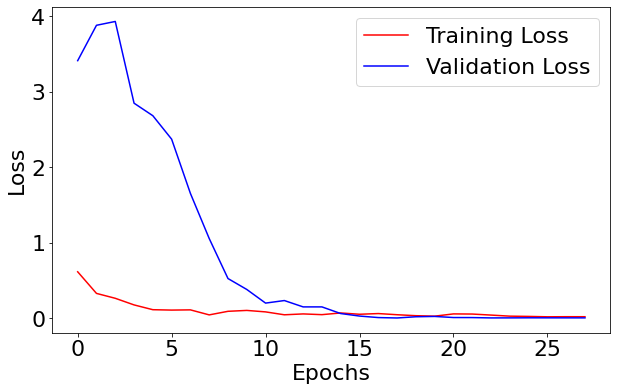

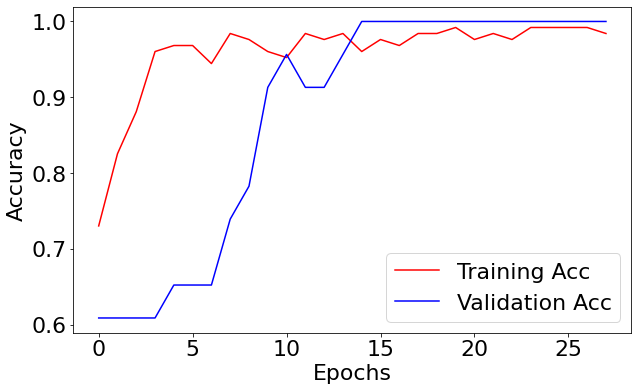

In [17]:
#Plotting the learning curves.
plot_training_curves(history)

In [18]:
#Load optimal weights computed during training.
model.load_weights(WEIGHTS_FILE)
#Make precictions on test set and print model's accuracy.
f1_score(denormalise(y_test), 
         denormalise(model.predict(X_test)),
         average='micro')

0.9629629629629629

## Possible Extensions
1. Evaluate the model with other metrics.
2. Try different dropout rates and neurons in the fully-connected part of the network.
3. Try different epochs and batch sizes.

## Bibliography
Bengio, Y., 2012. Deep Learning of Representations for Unsupervised and Transfer Learning. In: Journal of Machine Learning Research; 17–37.

Wang, G., Sun, Y., Wang, J., (2017). Automatic Image-Based Plant Disease Severity Estimation Using Deep Learning. Computational Intelligence and Neuroscience; 2017:8.

Mehdipour-Ghazi, M., Yanikoglu, B.A., & Aptoula, E. (2017). Plant identification using deep neural networks via optimization of transfer learning parameters. Neurocomputing, 235, 228-235.

Suh, H.K., IJsselmuiden, J., Hofstee, J.W., van Henten, E.J., (2018). Transfer learning for the classification of sugar beet and volunteer potato under field conditions. Biosystems Engineering; 174:50–65.

Kounalakis T., Triantafyllidis G. A., Nalpantidis L., (2019). Deep learning-based visual recognition of rumex for robotic precision farming. Computers and Electronics in Agriculture.

Espejo-Garcia, B., Mylonas, N., Athanasakos, L., & Fountas, S., (2020). Improving
Weeds Identification with a Repository of Agricultural Pre-trained Deep Neural
Networks. Computers and Electronics in Agriculture; 175 (August).